In [2]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn.linear_model import LogisticRegression

sys.path.append("..")
import src

primary, accent = src.theme.set()
pal = sns.color_palette("wfondrie")

def save(fname):
    """Save the figures"""
    figures = Path("figures")
    figures.mkdir(exist_ok=True)
    if not fname.startswith("08_"):
        fname = "08_" + fname
        
    if not fname.endswith(".png"):
        fname += ".png"
    
    plt.tight_layout(pad=0.2)
    plt.savefig(figures / fname, dpi=300)

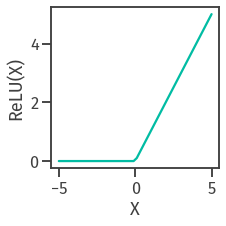

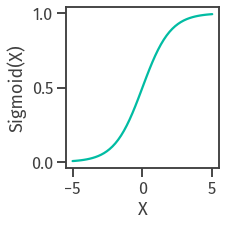

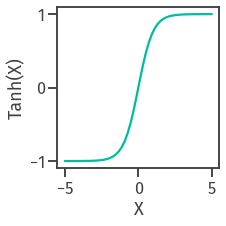

In [31]:
X = np.linspace(-5, 5)

def relu(X):
    X = X.copy()
    X[X <= 0] = 0
    return X

def sigmoid(X):
    return np.exp(X) / (1 + np.exp(X))

def tanh(X):
    return np.tanh(X)

funcs = [relu, sigmoid, tanh]
labs = ["ReLU(X)", "Sigmoid(X)", "Tanh(X)"]
for func, lab in zip(funcs, labs):
    plt.figure(figsize=(3, 3))
    plt.plot(X, func(X))
    plt.xlabel("X")
    plt.ylabel(lab)
    stem = lab.replace("(X)", "").lower()
    save(stem)

/var/folders/8x/xhjqq1ss58jcyc89wf32hc0c0000gn/T/ipykernel_86249/1106206302.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2, figsize=(9, 4))


array([<AxesSubplot:xlabel='Parameter value', ylabel='Loss'>,
       <AxesSubplot:xlabel='Parameter value', ylabel='Gradient'>],
      dtype=object)

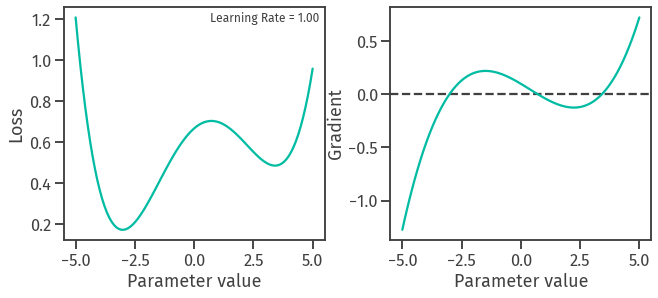

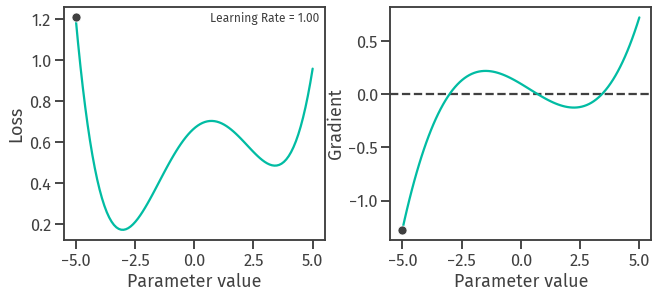

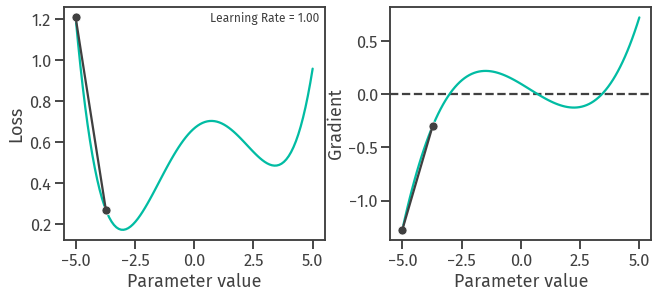

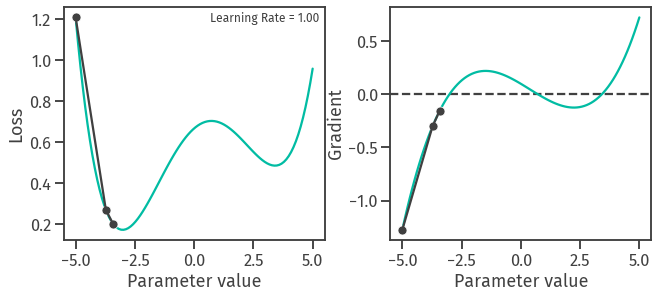

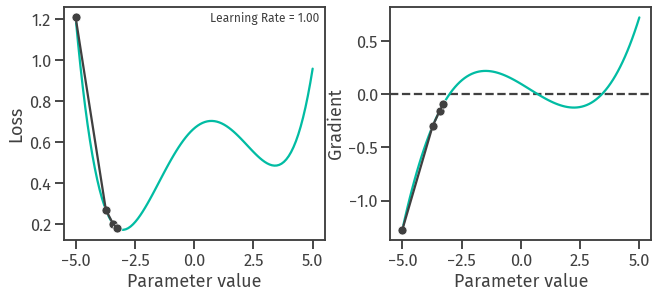

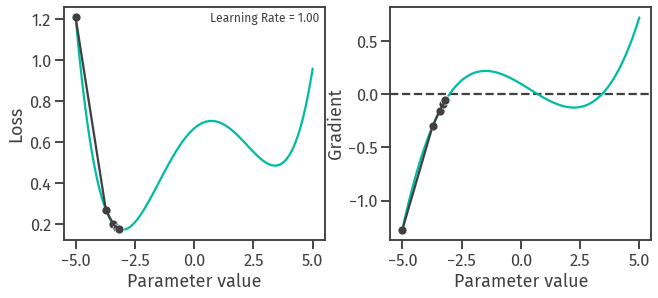

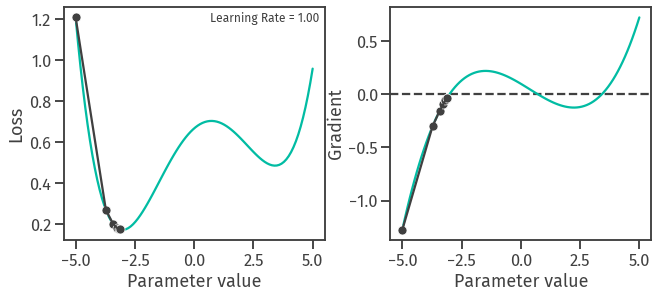

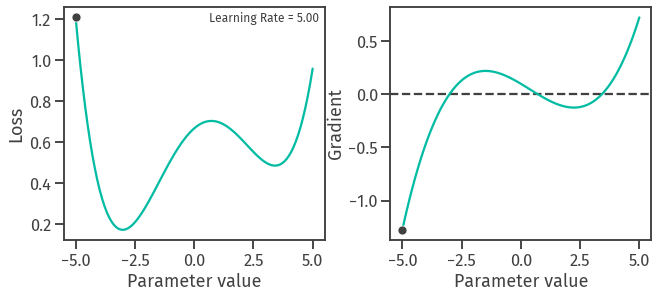

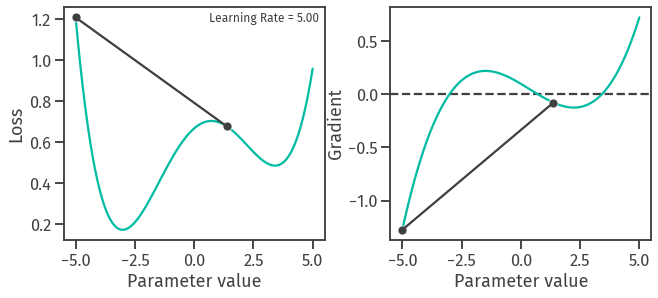

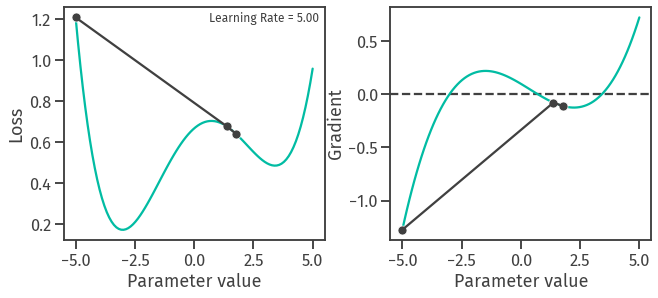

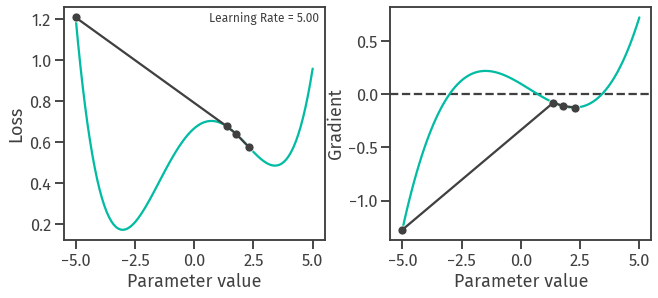

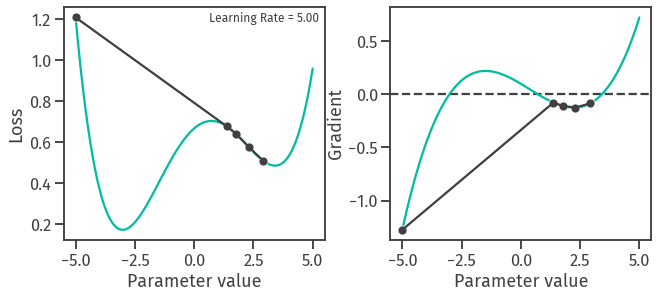

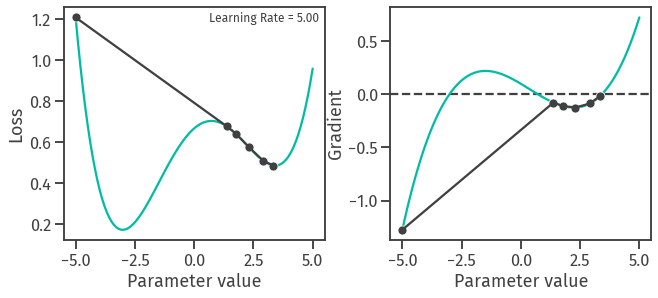

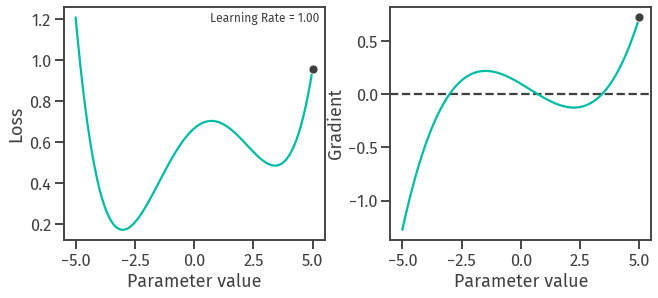

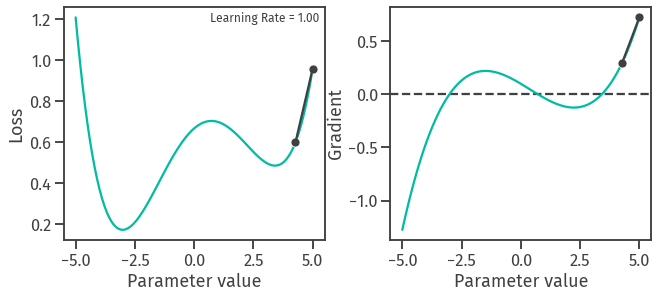

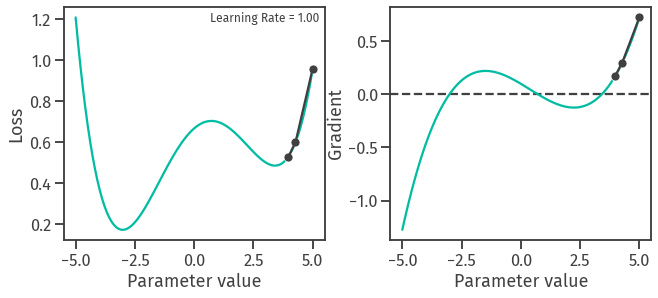

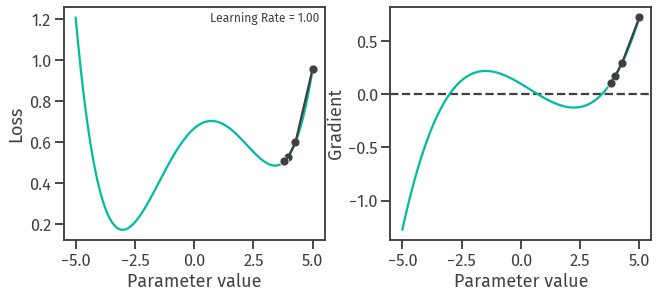

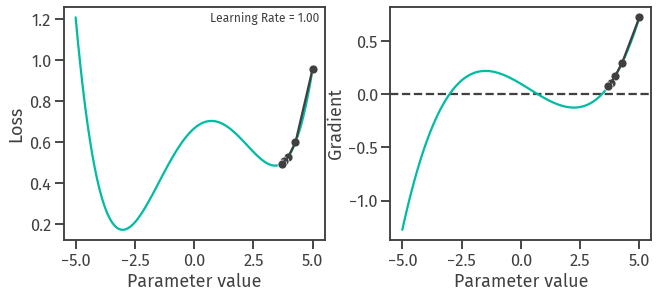

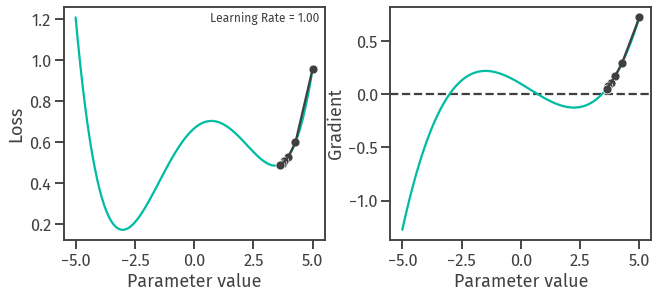

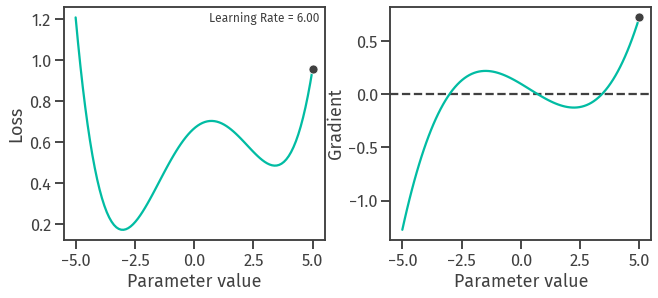

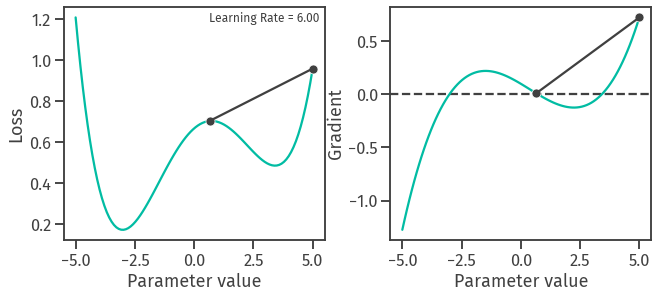

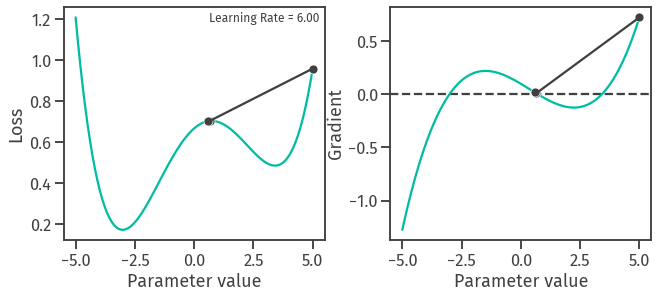

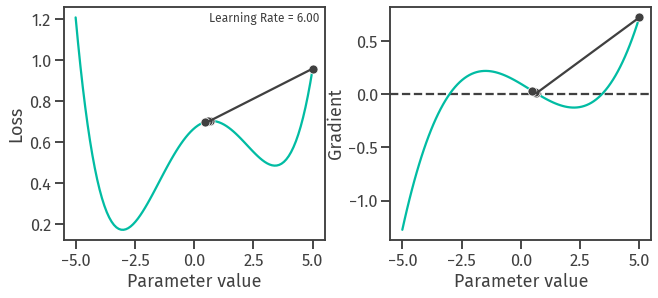

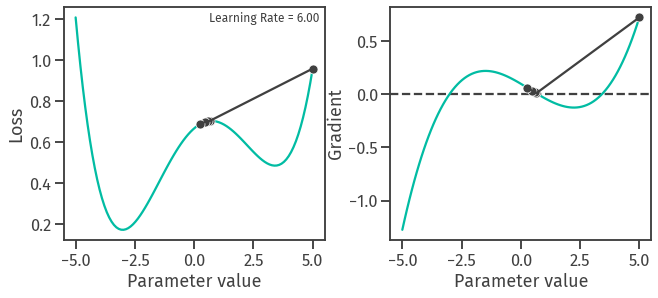

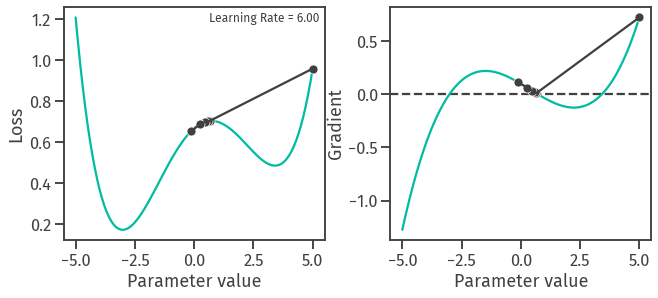

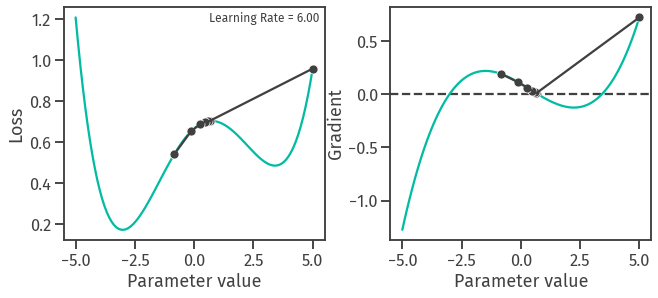

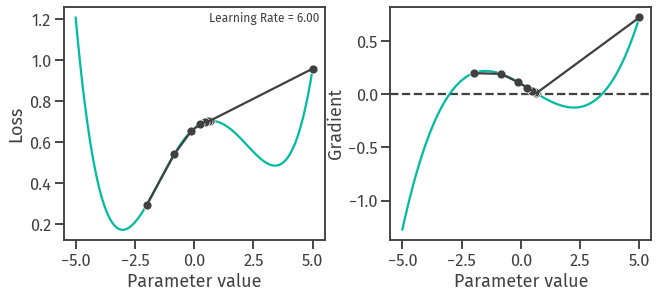

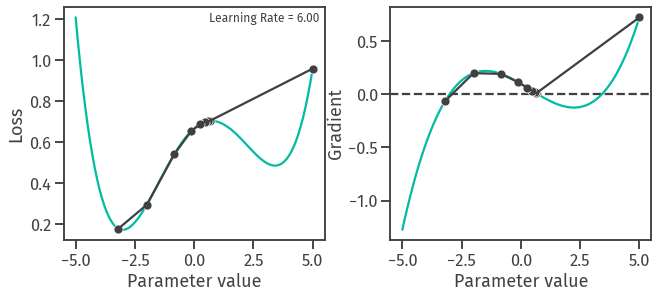

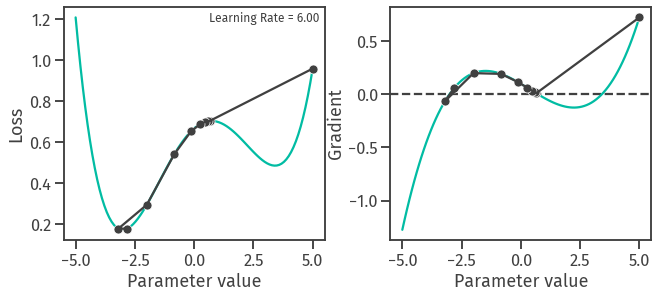

In [120]:
import torch

def grad_example(fname, start=None, n_iter=10, lr=1):
    def f(X):
        return (X*(X**2-20)*(X-1.5) + 200) / 300
    
    def mk_axes():
        X = torch.linspace(-5, 5, 100, requires_grad=True)
        L = f(X)
        L_grad = torch.ones_like(X)
        L.backward(gradient=L_grad)
        
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        axs[0].plot(X.detach().numpy(), L.detach().numpy())
        axs[1].plot(X.detach().numpy(), X.grad)
        axs[0].set_ylabel("Loss")
        axs[1].set_ylabel("Gradient")
        axs[1].axhline(0, linestyle="dashed", color=primary, zorder=1)
        axs[0].annotate(
            f"Learning Rate = {lr:.2f}", 
            (0.98, 0.98),
            xycoords="axes fraction", 
            ha="right",
            va="top",
            fontsize="large",
        )
        for ax in axs:
            ax.set_xlabel("Parameter value")
        
        return axs
    
    if start is None:
        axs = mk_axes()
        save(fname)
        return axs
    
    prev_X = []
    prev_L = []
    prev_G = []
    X = torch.tensor(start, requires_grad=True, dtype=float)
    for i in range(n_iter):
        axs = mk_axes()
        L = f(X)
        L.backward()
        prev_X.append(X.detach().item())
        prev_L.append(L.detach().item())
        prev_G.append(X.grad.item())
        
        sns.scatterplot(x=prev_X, y=prev_L, color=primary, zorder=5, ax=axs[0])
        axs[0].plot(prev_X, prev_L, c=primary, zorder=5)
        sns.scatterplot(x=prev_X, y=prev_G, color=primary, zorder=5, ax=axs[1])
        axs[1].plot(prev_X, prev_G, c=primary, zorder=5)
        save(f"{fname}_{str(i).zfill(2)}")
        step = -X.grad * lr
        with torch.no_grad():
            X += step
            X.grad.detach_()
            X.grad.zero_()
        
    return axs
        

grad_example("gd_blank")
grad_example("gd_left", -5, 6, 1)
grad_example("gd_left-fast", -5, 6, 5)
grad_example("gd_right", 5, 6, 1)
grad_example("gd_fast", 5, 10, 6)

## LR = 1